In [2]:
import MDAnalysis as mda
from numpy import *
import os
from pylab import *
import MDAnalysis.analysis.distances
import MDAnalysis.analysis.rms
from MDAnalysis.analysis import align
import glob
#import umap
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
import mdtraj
import pandas as pd
import seaborn as sns
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [3]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=sorted(glob.glob(h2opath+"*.gro"))
peggros=sorted(glob.glob(pegpath+"*.gro"))

#glob tprs
h2otprs=sorted(glob.glob(h2opath+"*.tpr"))
pegtprs=sorted(glob.glob(pegpath+"*.tpr"))

#trjs
h2otrjs=sorted(glob.glob(h2opath+"*.xtc"))
pegtrjs=sorted(glob.glob(pegpath+"*.xtc"))

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))#get universes 
#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2otprs[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(pegtprs[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper

#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#332288","#882255"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]



In [14]:
importantResids = [14,42,43,44,46,59,62,63,64,65,66,69,70,91,93,95,109,143,144,145,146,148,161,163,177,181,197,198,199,213,214,215]



importantrgsca=[]
stderrs=[]
for i in range(len(systems)):
    sub=[]
    for j in range(len(systems[i])):
        rg=[]
        for ts in range(len(systems[i][j].trajectory)): 
            systems[i][j].trajectory[ts]
            pocketSelectionString = "protein and name CA and ("
            for k in range(len(importantResids)):
                pocketSelectionString+= "resid " + str(importantResids[k])+" or "
            pocketSelectionString=pocketSelectionString[:-4]+")"
            rg.append(systems[i][j].select_atoms(pocketSelectionString).radius_of_gyration())
        sub.append(rg)
    importantrgsca.append(sub)
    
    


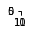

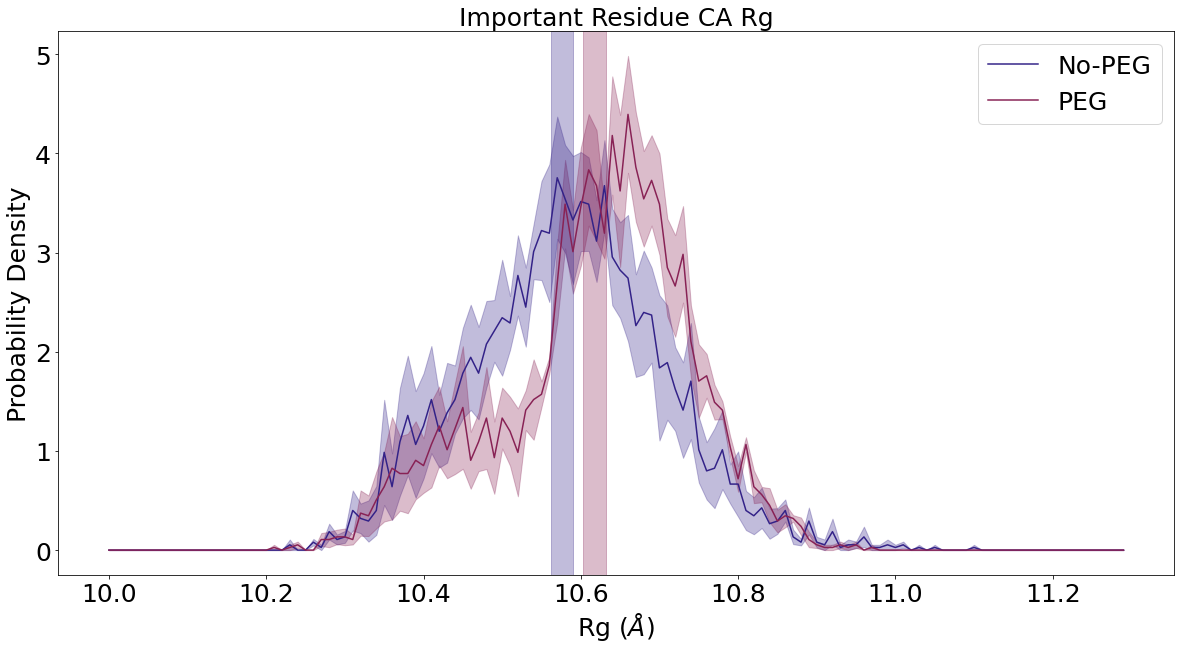

In [16]:
all_importantrg_histsca=[]
figure(figsize = (0,0))

for i in range(len(importantrgsca)):
    sub=[]
    for j in range(len(importantrgsca[i])):
        a=hist(importantrgsca[i][j][EQPOINT:],bins = arange(10,11.3,0.01),density = True,alpha = 0.8,color= colourScheme[0],label = system_names[0])
        sub.append(a[0])
    all_importantrg_histsca.append(sub)
    
system_avg_importantrgsca=[]
system_sem_importantrgsca=[]

for i in range(len(all_importantrg_histsca)):
    system_avg_importantrgsca.append(mean(all_importantrg_histsca[i],axis = 0))
    system_sem_importantrgsca.append(scipy.stats.sem(all_importantrg_histsca[i],axis = 0))
    
    
    
    
trjmeans = []
for i in range(len(importantrgsca)):
    sub = []
    for j in range(len(importantrgsca[i])):
        sub.append(mean(importantrgsca[i][j]))
    trjmeans.append(sub)
    
actualMean= [mean(trjmeans[0]),mean(trjmeans[1])]
actualSem = [scipy.stats.sem(trjmeans[0]),scipy.stats.sem(trjmeans[1])]




figure(figsize = (20,10))
plot(arange(10,11.3,0.01)[:-1],system_avg_importantrgsca[0],color = colourScheme[0],label = system_names[0])
plot(arange(10,11.3,0.01)[:-1],system_avg_importantrgsca[1],color = colourScheme[1],label = system_names[1])


fill_between(arange(10,11.3,0.01)[:-1], system_avg_importantrgsca[0] - system_sem_importantrgsca[0],system_avg_importantrgsca[0] + system_sem_importantrgsca[0],color = colourScheme[0],alpha = 0.3)
fill_between(arange(10,11.3,0.01)[:-1], system_avg_importantrgsca[1] - system_sem_importantrgsca[1],system_avg_importantrgsca[1] + system_sem_importantrgsca[1],color = colourScheme[1],alpha = 0.3)


xlabel("Rg ($\AA$)",fontsize = 25)
ylabel("Probability Density",fontsize = 25)
title("Important Residue CA Rg",fontsize = 25)
xticks(fontsize = 25)
yticks(fontsize = 25)

legend(fontsize = 25)


axvspan(actualMean[0] - actualSem[0],actualMean[0]+actualSem[0], color = colourScheme[0], alpha = 0.3)
axvspan(actualMean[1] - actualSem[1],actualMean[1]+actualSem[1], color = colourScheme[1], alpha = 0.3)




In [17]:
save("ImportantResidueCARgs.npy",importantrgsca)